# Extract formants and fundamental frequency

Requirements:  <br/>
`pip install praat-parselmouth` (pip3 does not work)  <br/>
`pip3 install pandas`  <br/>
`pip3 install pydub`  <br/>
`pip3 install seaborn`

Tutorials / source code: 
- http://blog.syntheticspeech.de/2021/03/10/how-to-extract-formant-tracks-with-praat-and-python/ 
- https://github.com/drfeinberg/PraatScripts/blob/master/Measure%20Pitch%20and%20HNR.ipynb  

In [ ]:
! pip install praat-parselmouth
! pip3 install pandas
! pip3 install pydub
! pip3 install seaborn

In [1]:
import parselmouth 
from parselmouth import praat

import math
import pydub
from pydub import AudioSegment

from os import listdir
from os.path import isfile, join
import re

import numpy as np 

import glob
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

/Users/anne/Desktop/VAE_Speech_Decomposition/speechTech/lib/python3.7/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [52]:
## Split audios into chunks of appropriate duration 

class SplitWavAudio():
    '''
    Split sounds into smaller chunks
    '''
    def __init__(self, folder, filename):
        self.folder = folder
        self.new_folder = folder + '_cut'
        self.filename = filename
        self.filepath = folder + '/' + filename
        
        self.audio = AudioSegment.from_wav(self.filepath)
    
    def get_duration(self):
        return self.audio.duration_seconds
    
    # def single_split(self, from_min, to_max, split_filename):
    #     t1 = from_min * 1000
    #     t2 = to_max * 1000
    #     split_audio = self.audio[t1:t2]
    #     split_audio.export(self.new_folder + '/' + split_filename, format="wav")
        
    # def multiple_split(self, split_interval):
    #     total_sec = math.floor(self.get_duration())
    #     for i in range(0, total_sec, split_interval):
    #         split_fn = str(i) + '_' + self.filename
    #         self.single_split(i, i+split_interval, split_fn)
    #         print(str(i) + ' Done')
    #         if i == total_sec - split_interval:
    #             print('All splited successfully')

    def single_split(self, from_min, to_max):
        t1 = from_min * 1000
        t2 = to_max * 1000
        split_audio = self.audio[t1:t2]
        return split_audio
    
    def multiple_split(self, split_interval):
        total_sec = math.floor(self.get_duration())
        for i in range(0, total_sec, split_interval):
            self.single_split(i, i+split_interval)
            print(str(i) + ' Done')
            if i == total_sec - split_interval:
                print('All splited successfully')    

    #def  oneSecSplit(self, split_interval):


def folder_split(folder, split_interval=1):
    '''
    Apply SplitWavAudio methods to a directory's files
    '''
    for f in listdir(folder):
        if isfile(join(folder, f)) and re.match(r'(.)*\.wav\b', f):
            split_wav = SplitWavAudio(folder, f)
            split_wav.multiple_split(split_interval)  



## Extract formants    

def extract_formants(sound_file, gender):
    '''
    Extract 3 first formants with Praat's functions thanks to Python's parselmouth
    '''
    time_step = 0.0025 # time between the centres of consecutive analysis frames 
    max_nb_formants = 5 # number of formants extracted per frame
    # formant_ceiling: maximum frequency of the formant search range, in Hertz
    window_length = 0.025 # duration of the analysis window (s)
    pre_emphasis = 50
    
    if gender == 'male':
        f0min = 100
        f0max = 150
        formant_ceiling = 5000 # An average adult male speaker has a vocal tract length that requires an average ceiling of 5000 Hz
        
    else: # gender == 'female'
        f0min = 200
        f0max = 300
        formant_ceiling = 5500 # An average adult female speaker has a vocal tract length that requires an average ceiling of 5500 Hz 
    
    # Transform  the file into a parselmouth object sound
    sound = parselmouth.Sound(sound_file) 

    # First, compute the occurrences of periodic instances in the signal:
    pointProcess = praat.call(sound, "To PointProcess (periodic, cc)", f0min, f0max)

    # Then, compute the formants: 
    formants = praat.call(sound, "To Formant (burg)", time_step, max_nb_formants, formant_ceiling, window_length, pre_emphasis) 

    # And finally assign formant values with times where they make sense (periodic instances):
    numPoints = praat.call(pointProcess, "Get number of points")
    f1_list = []
    f2_list = []
    f3_list = []
    for point in range(0, numPoints):
        point += 1
        t = praat.call(pointProcess, "Get time from index", point)
        f1 = praat.call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = praat.call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = praat.call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)

    # Create a matrix of formants 
    formant_tuple = (np.array(f1_list), np.array(f2_list), np.array(f3_list))
    formant = np.vstack(formant_tuple)
    formant = formant[~np.isnan(formant)] # We should check that nan values appear in the same places 
    
    return formant


def folder_formants_init(folder, gender):
    '''
    folder: directory containing .wav files with the right duration
    new_file: name of the file where the results are stored in a matrix format: for each recording[f1_list, f2_list, f3_list]
    '''
    init = True
    for f in listdir(folder):
        if isfile(join(folder, f)) and re.match(r'(.)*\.wav\b', f):
            file_path = folder + '/' + f
            if init: 
                formants = extract_formants(file_path, gender)
                init = False
            else:  
                formants = extract_formants(file_path, gender)
            with open(folder + '.csv','a') as fd:
                fd.write(np.array2string(formants))  


def folder_formants(folder, gender):
    '''
    folder: directory containing .wav files with the right duration
    '''
    # Create lists to put the results
    file_list = []
    formants_list = []

    # Go through all the wave files in the folder and measure pitch
    for wave_file in glob.glob(folder + '/*.wav'):
        formants = extract_formants(wave_file, gender)
        file_list.append(wave_file) # make an ID list
        formants_list.append(formants) # f0

    with open('formants_' + gender + '.csv','a') as fd:
            fd.write(str(list(zip(file_list, formants_list))))

Here we measure mean values.

In [ ]:
## Measure pitch of all wav files in directory

def measureMeanPitch(voiceID, f0min, f0max, unit): 
    '''
    Measure voice pitch
    '''
    sound = parselmouth.Sound(voiceID) # read the sound
    pitch = praat.call(sound, "To Pitch", 0.0, f0min, f0max) # create a praat pitch object
    meanF0 = praat.call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = praat.call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = praat.call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = praat.call(harmonicity, "Get mean", 0, 0) # get harmonics to noise ratio 

    return meanF0, stdevF0, hnr

def meanPitchList(folder, gender): 
    # Create lists to put the results
    file_list = []
    mean_F0_list = []
    sd_F0_list = []
    hnr_list = []

    # Go through all the wave files in the folder and measure pitch
    for wave_file in glob.glob(folder + '/*.wav'):
        sound = parselmouth.Sound(wave_file)
        (meanF0, stdevF0, hnr) = measureMeanPitch(sound, 75, 500, "Hertz")
        file_list.append(wave_file) # make an ID list
        mean_F0_list.append(meanF0) # make a mean F0 list
        sd_F0_list.append(stdevF0) # make a sd F0 list
        hnr_list.append(hnr)

    df = pd.DataFrame(np.column_stack([file_list, mean_F0_list, sd_F0_list, hnr_list]), 
                                columns=['voiceID', 'meanF0Hz', 'stdevF0Hz', 'HNR'])  #add these lists to pandas in the right order

    # Write out the updated dataframe
    df.to_csv('processed_results_' + gender + '.csv', index=False)

Here we want to have the evolution of the pitch contour with time.

https://zuker.io/articles/2019-07/parselmouth-contour 


In [40]:
# Draw pitch 
def measurePitch(voiceID, gender, unit='Hertz'): 
    '''
    Measure voice pitch
    '''
    if gender == 'male':
        f0min = 50
        f0max = 200 
        
    else: # gender == 'female'
        f0min = 150
        f0max = 350
    
    sound = parselmouth.Sound(voiceID) # read the sound
    pitch = praat.call(sound, "To Pitch", 0.0, f0min, f0max) # create a praat pitch object

    return pitch 

def pitchList(folder, gender): 
    # Create lists to put the results
    file_list = []
    pitch_list = []

    # Go through all the wave files in the folder and measure pitch
    for wave_file in glob.glob(folder + '/*.wav'):
        pitch = measurePitch(wave_file, gender)
        pitch_values = pitch.selected_array['frequency']
        file_list.append(wave_file) # make an ID list
        pitch_list.append(pitch_values) # f0

    with open('pitch_contour_' + gender + '.csv','a') as fd:
                fd.write(str(list(zip(file_list, pitch_list))))
                

## Visualisation 

def plotOnGraph(pitch, color):
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2.5, color=color)
    
def setupGraph(ymin, ymax):
    sns.set() # Use seaborn's default style to make attractive graphs
    plt.rcParams['figure.dpi'] = 150 # Show images nicely
    plt.figure()
    plt.ylim(ymin, ymax)
    plt.ylabel("frequency [Hz]")
    plt.xlabel("seconds")
    plt.grid(True)


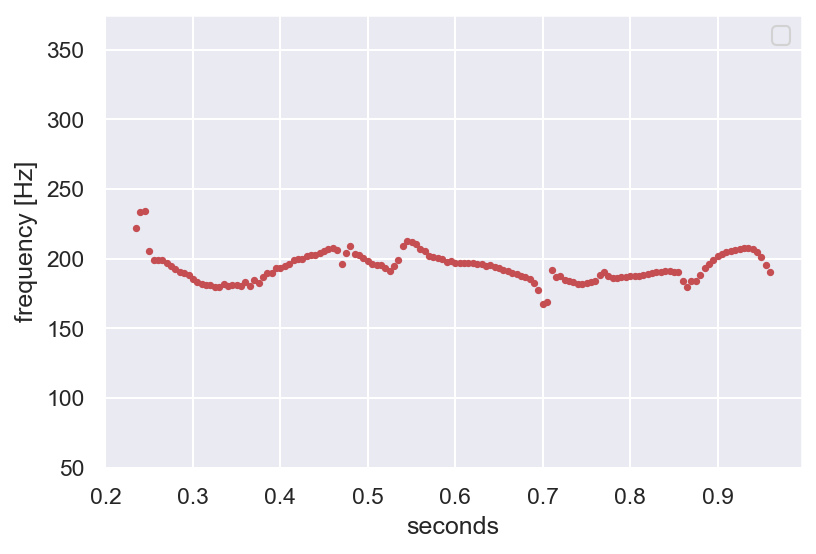

In [38]:
# Example of pitch contour
pitch1 = measurePitch('Dataset/wav/female_cut/0_arctic_a0008.wav', 'female', unit='Hertz') 

setupGraph(50, 375)
plotOnGraph(pitch1, 'r')
plt.gca().legend((''))
plt.show()

In [ ]:
def specToAudio(x):
    return librosa.griffinlim(x)

### Extract formants

In [55]:
# Create the directory female_cut if it does not exist already. 
repository = 'Dataset/wav/female' 
chunks_repository = repository + '_cut'

if not os.path.exists(chunks_repository):
    os.makedirs(chunks_repository)
    folder_split(repository, split_interval=1)

# Save lists of formants of all the files in the repository in a csv file. Note that lists of formants don't have the same length necessarily (some look empty?)
folder_formants(chunks_repository, 'female')

In [59]:
# Create the directory male_cut if it does not already exist. 
repository = 'Dataset/wav/male'
chunks_repository = repository + '_cut'
if not os.path.exists(chunks_repository):
    os.makedirs(chunks_repository)
    folder_split(repository , split_interval=1)

# Save lists of formants of all the files in the repository in a csv file. Note that lists of formants don't have the same length necessarily (some look empty?)
folder_formants(chunks_repository, 'male')

### Extract fundamental frequency and pitch-related information

Below, code to get mean values.

In [6]:
# Female voices
repository = 'Dataset/wav/female_cut'
meanPitchList(repository, 'female')

# Male voices
repository = 'Dataset/wav/male_cut'
meanPitchList(repository, 'male')

Code to get pitch contour.

In [42]:
repository = 'Dataset/wav/female_cut'
pitchList(repository, 'female')

# Male voices
repository = 'Dataset/wav/male_cut'
pitchList(repository, 'male')